In [8]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import json
import h5py
import pickle

In [10]:
data = {}
batchNames = ['v109_batch1']
paramsNameList = ['Spontaneous']

for labelNumber,batchName in enumerate(batchNames):

    paramsName = paramsNameList[labelNumber]
    data[paramsName] = {}
    
    hf = h5py.File(batchName+'/RasterPlot.h5', 'r')
    spkid = np.array(hf.get('spkid'))
    spkt = np.array(hf.get('spkt'))
    hf.close()

    hf = h5py.File(batchName+'/Voltage_soma.h5', 'r') 
    
    cellVNumber = []
    data[paramsName]['V_soma'] = {}    
    
    cellVNumber = []
    for cellName in list(hf.keys()):
        cellVNumber.append(int(cellName.split('_')[1]))
    cellVNumber = np.sort(cellVNumber)   
    
    for cellName in cellVNumber:
        Vt = np.array(hf.get('cell_'+str(cellName)))
        data[paramsName]['V_soma']['cell_'+str(cellName)] = Vt
        
    hf.close()
    
    data[paramsName]['spkid'] = spkid
    data[paramsName]['spkt'] = spkt

In [11]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../sim/cells/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

popNumber = {}
cellNumber = {} 
popLabel = {} 
cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cellNumber[metype] = int(n)
    popLabel[metype] = mtype
    popNumber[mtype] = int(m)
    cellLabel[metype] = cellname

#------------------------------------------------------------------------------  
# Thalamic Cells

thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

cellNumber['ss_RTN_o'] = int(382 * (210**2/150**2)) # from mouse model (d = 150 um)
cellNumber['ss_RTN_m'] = int(382 * (210**2/150**2))
cellNumber['ss_RTN_i'] = int(765 * (210**2/150**2))
cellNumber['VPL_sTC'] = int(656 * (210**2/150**2))
cellNumber['VPM_sTC'] = int(839 * (210**2/150**2))
cellNumber['POm_sTC_s1'] = int(685 * (210**2/150**2))

for mtype in thalamicpops: # No diversity
	metype = mtype
	popLabel[metype] = mtype
	popNumber[mtype] = cellNumber[metype]

#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------

## Load spkTimes and cells positions
with open('../data/spkTimes_v9_batch8.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)
spkTimes = simData['spkTimes']
cellsTags = simData['cellsTags']

# create custom list of spike times
cellsVSName = {}
for cellLabel in spkTimes.keys():    
    cellme = cellLabel.split('_')[0:-1]    
    metype = cellme[0]
    for i in range(1,np.size(cellme)):
        metype += '_' + cellme[i]
                   
    if metype not in cellsVSName.keys():
        cellsVSName[metype] = []
        
    mtype = popLabel[metype]            
    cellsVSName[metype].append('presyn_'+cellLabel)

#------------------------------------------------------------------------------
cynradNumber = 1
fracmorphoradius = 1.0/2.0

excluderadius2a = (cynradNumber-1)*(0.5*fracmorphoradius)**2
excluderadius2b = (cynradNumber)*(0.5*fracmorphoradius)**2

Nmorpho = {}    
listmorphonumber = {}

print('radius from',420*np.sqrt(excluderadius2a),'to',420*np.sqrt(excluderadius2b),'micrometers')

#------------------------------------------------------------------------------
# create 1 vectstim pop per cell gid
for metype in cellsVSName.keys(): # metype
       
    for cellLabel in cellsVSName[metype]: # all cells in metype

        mtype = popLabel[metype]    
        ii = int(cellLabel.split('_')[-1])
        radiuscCell2 = (cellsTags[ii]['xnorm']-0.5)**2 + (cellsTags[ii]['znorm']-0.5)**2

        if metype[0] == 'L' and radiuscCell2 >= excluderadius2a and radiuscCell2 < excluderadius2b:   

            if metype not in listmorphonumber.keys():
                listmorphonumber[metype] = []

            listmorphonumber[metype].append(ii)     

            if metype not in Nmorpho.keys():
                Nmorpho[metype] = 0

            Nmorpho[metype] += 1

#------------------------------------------------------------------------------
Epopsall = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
Epops = [] 
S1pops = []
S1cells = []
popLabelEl = {}

for metype in  Nmorpho.keys(): # metype      
    if  Nmorpho[metype] > 0:  
        S1cells.append(metype)
        mtype = popLabel[metype]            
        if mtype in Epopsall:            
            if mtype not in Epops:
                Epops.append(mtype)
                S1pops.append(mtype)
                popLabelEl[mtype] = [] 
            popLabelEl[mtype].append(metype)            
        else:            
            if mtype not in Ipops:                
                Ipops.append(mtype)  
                S1pops.append(mtype)  
                popLabelEl[mtype] = [] 
            popLabelEl[mtype].append(metype)      

#------------------------------------------------------------------------------  
#
#------------------------------------------------------------------------------  
popParamLabels = S1pops
cellParamLabels = S1cells

#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
allpops = cellParamLabels
cellsrec = 2
if cellsrec == 0:  recordCells = allpops # record all cells
elif cellsrec == 1: recordCells = [(pop,0) for pop in allpops] # record one cell of each pop
elif cellsrec == 2: # record one cell of each cellMEtype # need more test!!!
    recordCells = []
    for metype in cellParamLabels:
        if Nmorpho[metype] < 5:
            for numberME in range(Nmorpho[metype]):
                recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = Nmorpho[metype] - 5.0*int(Nmorpho[metype]/5.0)
            
            for number in range(5):            
                recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(Nmorpho[metype]/5.0))  
                else:
                    numberME+=int(Nmorpho[metype]/5.0)


radius from 0.0 to 105.0 micrometers


In [39]:
recordCellsmetype = []
recordCellsmtype = []

for ii,recc in enumerate(recordCells):
#     print(ii,recc[0], recc[1])
    recordCellsmetype.append(recc[0])
    recordCellsmtype.append(popLabel[recc[0]])

In [12]:
paramsNameList

['Spontaneous']

In [54]:
Epops

['L23_PC',
 'L4_PC',
 'L4_SP',
 'L4_SS',
 'L5_STPC',
 'L5_TTPC1',
 'L5_TTPC2',
 'L5_UTPC',
 'L6_BPC',
 'L6_IPC',
 'L6_TPC_L1',
 'L6_TPC_L4',
 'L6_UTPC']

In [65]:
printVt = ['L23_PC', 'L4_PC', 'L4_SP', 'L4_SS', 'L5_STPC', 'L5_TTPC1', 'L5_TTPC2', 'L5_UTPC', 'L6_BPC', 'L6_IPC', 'L6_TPC_L1', 'L6_TPC_L4', 'L6_UTPC']
# ['L1_SLAC','L23_LBC','L23_MC','L23_NBC','L23_NGC','L4_DBC','L4_MC','L4_NGC','L4_SS','L5_MC','L5_TTPC2','L6_MC','L6_TPC_L4','VPL_sTC','VPM_sTC','POm_sTC_s1']
# ['L1_DAC','L1_DLAC','L1_HAC','L1_NGC-DA','L1_NGC-SA','L1_SLAC','L23_BP','L23_BTC','L23_ChC','L23_DBC','L23_LBC','L23_MC','L23_NBC','L23_NGC','L23_PC'
# ,'L23_SBC','L4_BP','L4_BTC','L4_ChC','L4_DBC','L4_LBC','L4_MC','L4_NBC','L4_NGC','L4_PC','L4_SBC','L4_SP','L4_SS',
# 'L5_BP','L5_BTC','L5_ChC','L5_DBC','L5_LBC','L5_MC','L5_NBC','L5_NGC','L5_SBC','L5_STPC','L5_TTPC1','L5_TTPC2','L5_UTPC',
# 'L6_BPC','L6_BP','L6_BTC','L6_ChC','L6_DBC','L6_IPC','L6_LBC','L6_MC','L6_NBC','L6_NGC','L6_SBC','L6_TPC_L1','L6_TPC_L4','L6_UTPC','ss_RTN_o','ss_RTN_m','ss_RTN_i','VPL_sTC','VPM_sTC','POm_sTC_s1'

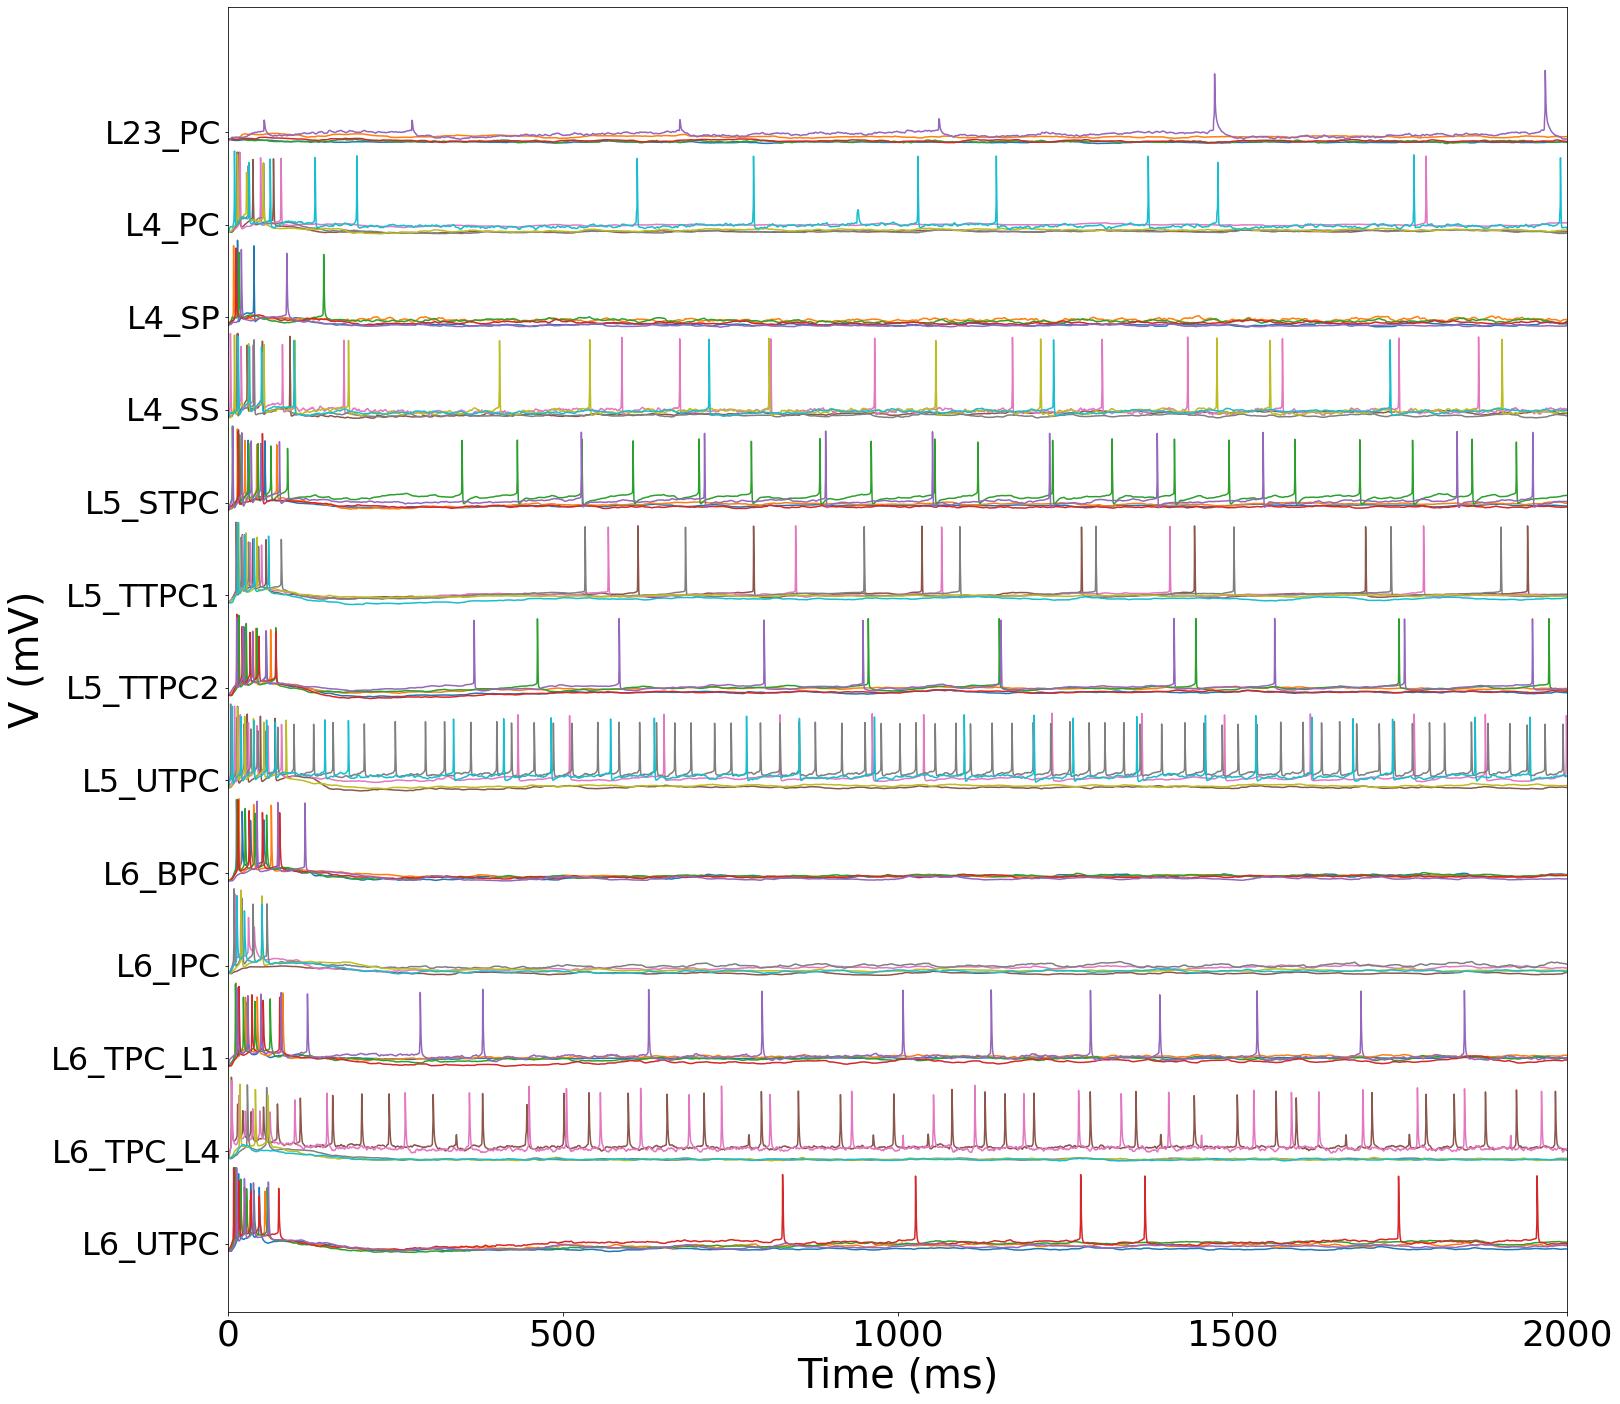

In [68]:
plt.figure(figsize=(24,24)) 
time = np.linspace(0, 15000, 150000)
plt.ylabel('V (mV)', fontsize=40)
plt.xlabel('Time (ms)', fontsize=40)
plt.xlim(0, 2000)
# plt.ylim(-80, -30)
# plt.ylim(-7390+6*120,20)
popinvert = printVt[::-1]
plt.yticks(np.arange(-7260+48*120,60,120),popinvert[0:13], fontsize=32)
plt.xticks(np.arange(0,2010,500),fontsize=36)

paramsName = paramsNameList[0]
number = 0
i2 = 0
for i,popName in enumerate(popLabelEl.keys()):     
    
    for metype in popLabelEl[popName]:
        
        if Nmorpho[metype] < 5:
            numberME = Nmorpho[metype]
        else:
            numberME = 5
            
        for j in range(numberME):    
            if popName in printVt:
                Vt = np.array(data[paramsName]['V_soma']['cell_'+str(cellVNumber[number])])
                plt.plot(time, (Vt-i2*120.0)) 
#                 print(i2, number, popName, recordCellsmetype[number], recordCellsmtype[number])
            number = number + 1

    if popName in printVt:
        i2+=1
        
plt.savefig('Vt_zoom_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

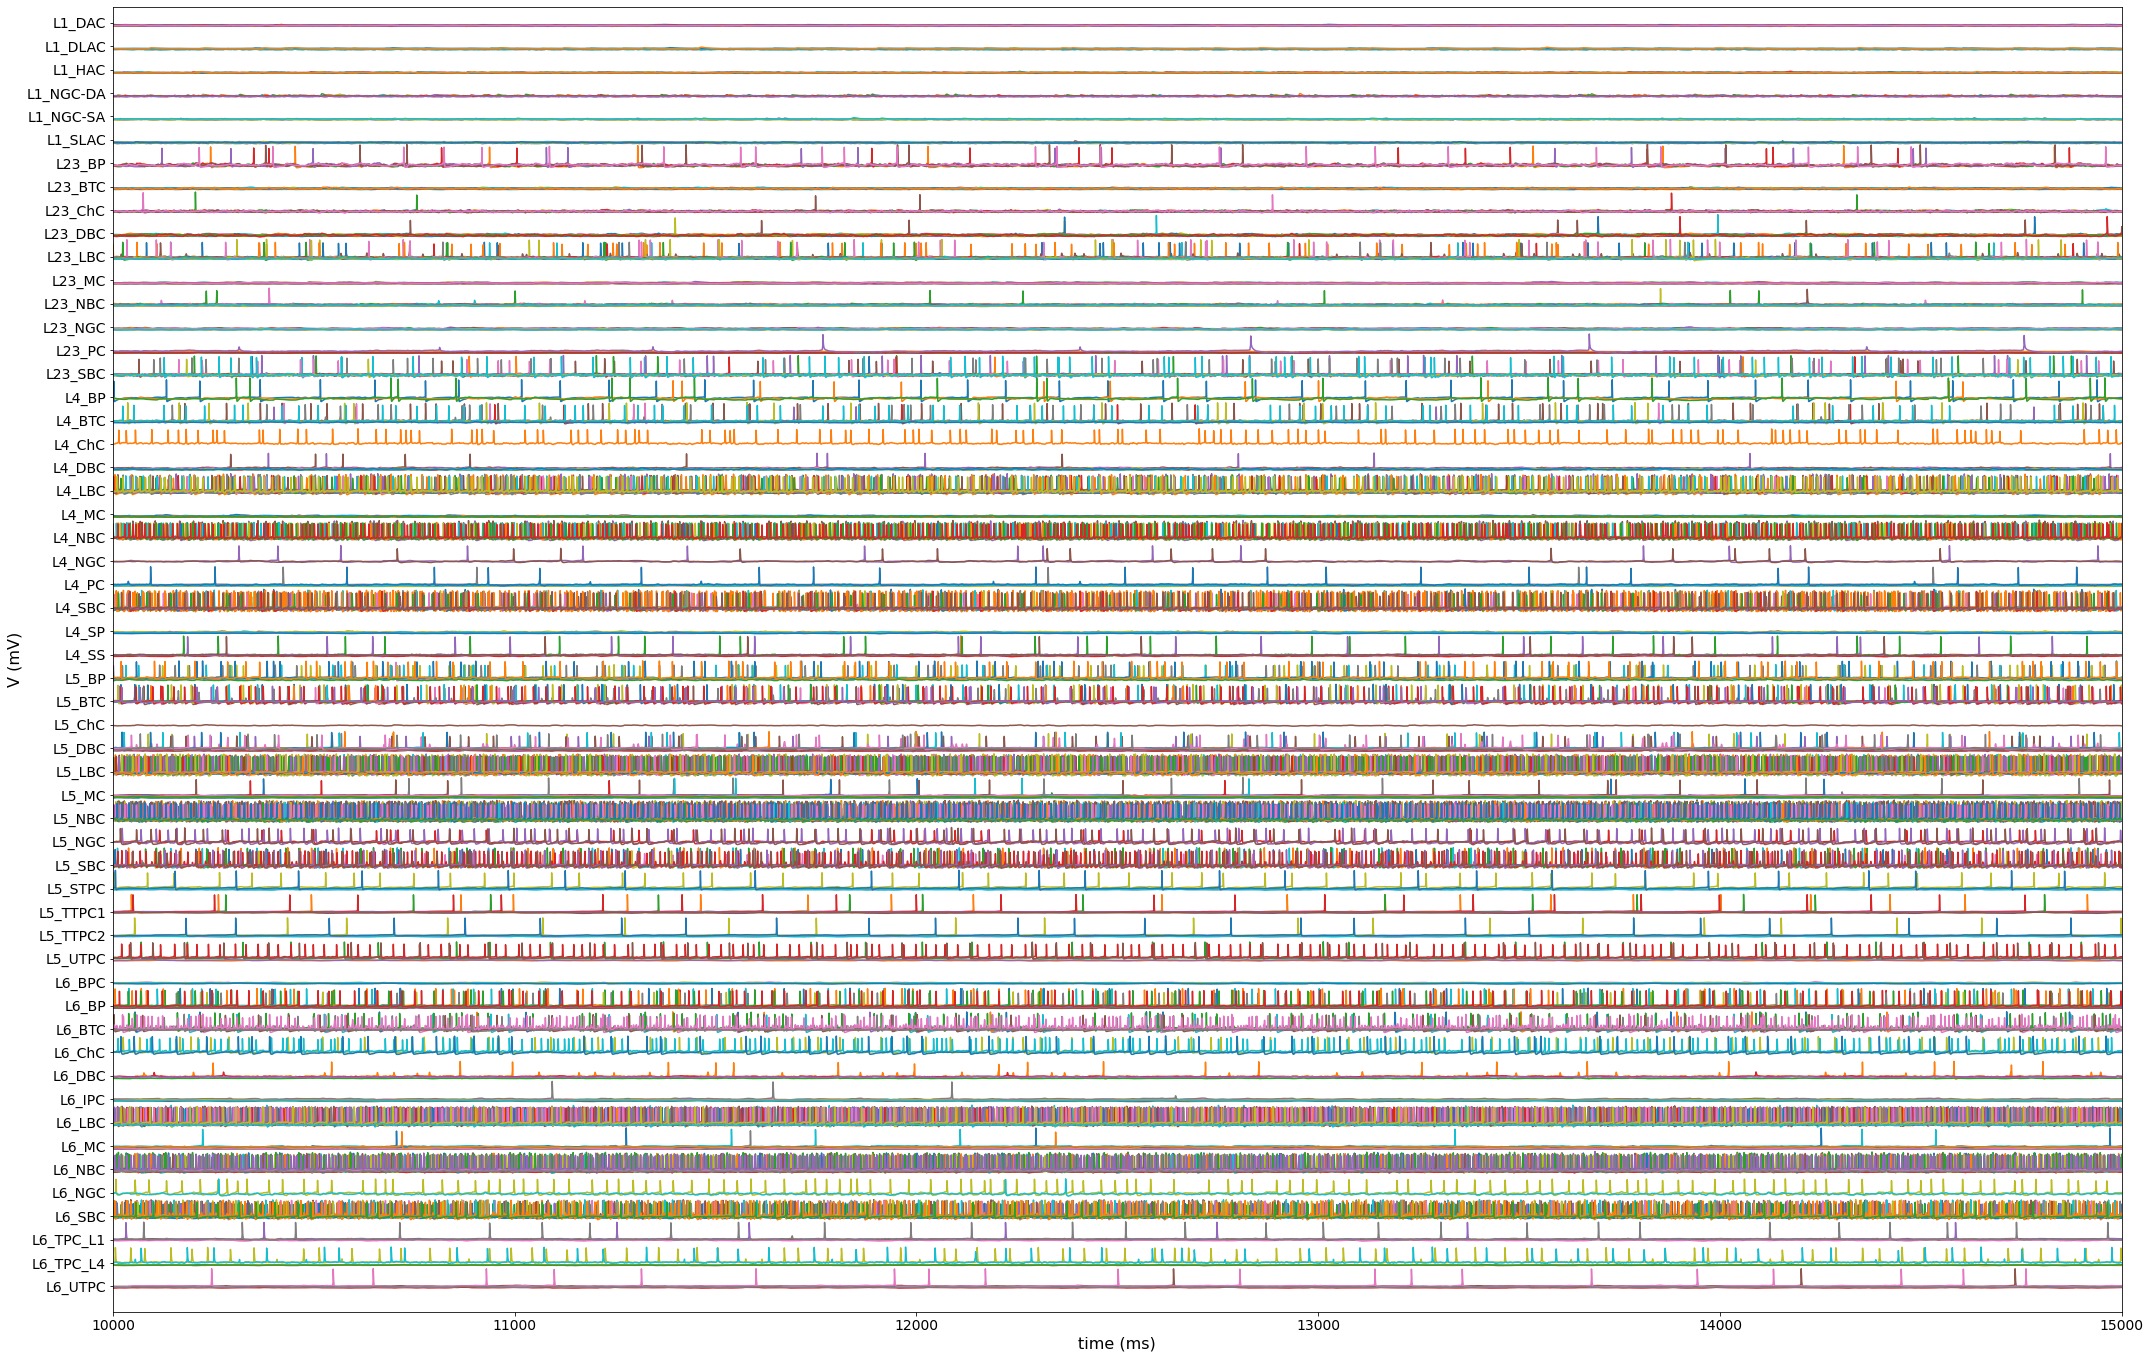

In [70]:
plt.figure(figsize=(36,24)) 
time = np.linspace(0, 15000, 150000)
plt.ylabel('V (mV)', fontsize=16)
plt.xlabel('time (ms)', fontsize=16)
plt.xlim(10000, 15000)
# plt.ylim(-80, -30)
plt.ylim(-7390+6*120,20)
popinvert = list(popLabelEl.keys())[::-1]
plt.yticks(np.arange(-7260+6*120,60,120),popinvert, fontsize=14)
plt.xticks(fontsize=14)

paramsName = paramsNameList[0]
number = 0
for i,popName in enumerate(popLabelEl.keys()):   
    for metype in popLabelEl[popName]:
        
        if Nmorpho[metype] < 5:
            numberME = Nmorpho[metype]
        else:
            numberME = 5
            
        for j in range(numberME):    
            Vt = np.array(data[paramsName]['V_soma']['cell_'+str(cellVNumber[number])])
            if popName in Epops:
                plt.plot(time, (Vt-i*120.0)) 
            else:
                plt.plot(time, (Vt-i*120.0)) 
            number = number + 1

plt.savefig('Vt_after-transient_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

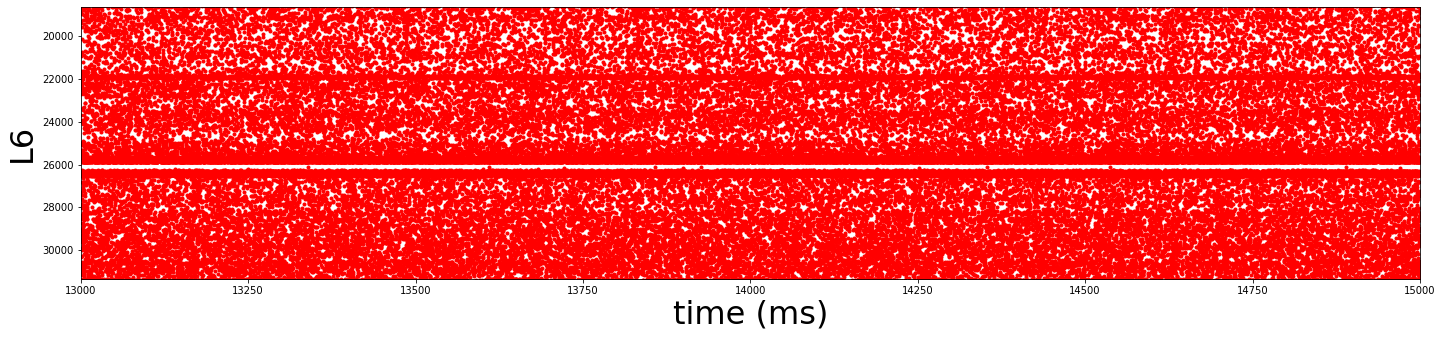

In [83]:
plt.figure(figsize=(24,5)) 

plt.ylabel('L6', fontsize=32)
plt.xlabel('time (ms)', fontsize=32)
plt.xlim(13000, 15000)
plt.ylim(31346, 18632)
# plt.yticks([18632,31346], fontsize=32)
# plt.xticks([1700,1750],[1700,1750],fontsize=32)
plt.plot(data[paramsName]['spkt'],data[paramsName]['spkid'], 'r.')



plt.savefig('Raster_zoom_L6_' + paramsName + '.png', facecolor = 'white', bbox_inches='tight' , dpi=300)

In [71]:
np.sum(popID3)

NameError: name 'popID3' is not defined

In [72]:
popID2 = []
popID3 = []
N = 0
for mtype in popNumber.keys():
    popID[mtype] = N
    popID2.append(N)
    N += popNumber[mtype]
    popID3.append(popNumber[mtype])
popID2.append(N)

NameError: name 'popID' is not defined

In [73]:
# L1:6 L23:10 L4:12 L5:13 L6:14
np.sum(popID3[41:55])

0.0

In [77]:
popID = {}
N = 0
for mtype in popNumber.keys():
    popID[mtype] = N
    N += popNumber[mtype]
    

spkid = list(data[paramsName]['simData']['spkid'])
spkt = list(data[paramsName]['simData']['spkt'])
print('N =',N,', Number of spikes =',np.size(spkt),', FR =',np.size(spkt)/(5.0*N))

#after transient
mtype = 'L23_PC'
popRates = []
popNames = []
for mtype in popParamLabels:
    popName = mtype
    FRafter = []
    for i in range(np.size(spkt)):
        if spkid[i] >= popID[mtype] and spkid[i] < popID[mtype]+popNumber[mtype] and spkt[i] > 500.0:
    #         print('%.3f %.0f' % (spkt[i],spkid[i]))
            FRafter.append(spkt[i])
         
    popRates.append(np.size(FRafter)/(4.5*(popNumber[mtype])))
    popNames.append(mtype)
    for metype in popLabelEl[mtype]:        
        print('%s (%d cells)\t %.3f\t %.3f\t'% (metype,popNumber[mtype],np.size(FRafter)/(4.5*(popNumber[mtype])),data[paramsName]['simData']['popRates'][metype]))

KeyError: 'simData'

In [75]:
popRates2 = popRates
popNames2 = popNames

NameError: name 'popRates' is not defined

NameError: name 'popNames2' is not defined

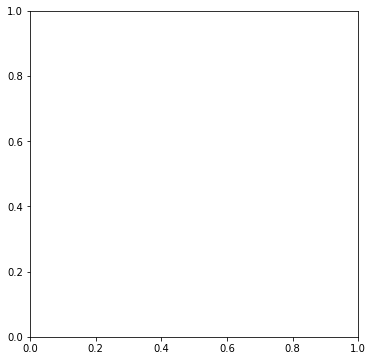

In [76]:
plt.figure(figsize=(20,6))
widths = 0.45
plt.subplot(1, 3, 1) 

popRates = []
popNames = []
for number,popName in enumerate(popNames2):
    if popName in Epops:
        popRates.append(popRates2[number])
        popNames.append(popName)
        
ind = np.arange(len(popNames))
plt.barh(ind,popRates, widths, color='red', label=paramsName) 

plt.ylim(12.5,-0.5)
plt.xlabel('F (Hz)', fontsize=18)
plt.yticks(ind, popNames, fontsize=10)
plt.legend(loc='upper right', bbox_to_anchor=(0.8, 1.0))
#----------------------------------------------------------------------------------
plt.subplot(1, 3, 2)  

popRates = []
popNames = []
for number,popName in enumerate(popNames2):
    if popName in Ipops[0:15]:
        popRates.append(popRates2[number])
        popNames.append(popName)
        
ind = np.arange(len(popNames))
plt.barh(ind,popRates, widths, color='red', label=paramsName) 

plt.ylim(14.5,-0.5)
plt.xlabel('F (Hz)', fontsize=18)
plt.yticks(ind, popNames, fontsize=10)
plt.legend(loc='upper right', bbox_to_anchor=(0.8, 1.0))
#----------------------------------------------------------------------------------
plt.subplot(1, 3, 3)   

popRates = []
popNames = []
for number,popName in enumerate(popNames2):
    if popName in Ipops[15:]:
        popRates.append(popRates2[number])
        popNames.append(popName)
        
ind = np.arange(len(popNames))
plt.barh(ind,popRates, widths, color='red', label=paramsName) 

plt.ylim(26.5,-0.5)
plt.xlabel('F (Hz)', fontsize=18)
plt.yticks(ind, popNames, fontsize=10)
plt.legend(loc='upper right', bbox_to_anchor=(0.8, 1.0))

namefig = '2.png'
plt.savefig(namefig, facecolor = 'white', bbox_inches='tight' , dpi=300)